In [22]:
import pandas as pd
import os
import numpy as np
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import pacf, acf
from pylab import rcParams

In [23]:
weather = pd.read_csv(r'.\data\interpolated_weather.csv')
weather = weather[(weather['province'].isin(['Hà Nội', 'Hưng Yên', 'Bắc Ninh']))]
weather.to_csv(r'.\data\weather_data.csv', index=False)

air = pd.read_csv(r'.\data\interpolated_air.csv')
air = air[(air['province'].isin(['Hà Nội', 'Hưng Yên', 'Bắc Ninh']))]
air.to_csv(r'.\data\air_data.csv', index=False)

df = pd.merge(weather, air, on=['time', 'province'], how='inner')


In [24]:
weather = pd.read_csv(r'.\data\weather_data.csv')
air = pd.read_csv(r'.\data\air_data.csv')

df = pd.merge(weather, air, on=['time', 'province'], how='inner')

In [25]:
df.isnull().sum()

time                    0
province                0
temperature_2m          0
relative_humidity_2m    0
dew_point_2m            0
precipitation           0
surface_pressure        0
cloud_cover             0
wind_speed_10m          0
wind_direction_10m      0
co                      0
no2                     0
o3                      0
so2                     0
pm2_5                   0
pm10                    0
aqi                     0
dtype: int64

In [26]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temperature_2m,104280.0,24.151310,5.632073,6.40,20.30,25.10,28.1000,39.00
relative_humidity_2m,104280.0,79.324386,14.511047,26.00,70.00,82.00,92.0000,100.00
dew_point_2m,104280.0,20.072746,6.290619,0.00,16.20,22.40,25.1000,29.50
precipitation,104280.0,0.241159,1.024142,0.00,0.00,0.00,0.1000,32.80
surface_pressure,104280.0,1010.024692,7.395462,980.90,1004.00,1009.50,1015.6000,1033.50
cloud_cover,104280.0,73.158516,37.005644,0.00,43.00,99.00,100.0000,100.00
wind_speed_10m,104280.0,9.439441,4.687206,0.00,5.90,8.90,12.5000,64.20
wind_direction_10m,104280.0,149.689528,101.907396,0.00,73.00,141.00,180.0000,360.00
co,104280.0,1369.952714,1209.524400,260.35,694.28,974.66,1548.7700,14312.74
no2,104280.0,35.874762,22.536648,1.99,20.39,31.53,45.9300,260.47


In [27]:
def savePlotAttributes(df, dir, resample_mode=None):
    # If 'province' column does not exist, plot all attributes for the whole DataFrame
    for attribute in df.columns:
        if attribute == 'time':
            continue  # skip time column if present
        fig = plt.figure(figsize=(16, 6))
        fig.suptitle(attribute, fontsize=20, y=0.95)

        if resample_mode and 'time' in df.columns:
            data = df.copy()
            data['time'] = pd.to_datetime(data['time'])
            data.set_index('time', inplace=True)
            series = data[attribute].resample(resample_mode).mean()
        else:
            series = df[attribute]

        ax = plt.subplot2grid((1, 1), (0, 0), rowspan=1, colspan=1)
        ax.plot(series)
        ax.set_title(attribute, fontsize=16)

        if 'time' in df.columns:
            for year in range(2021, 2026):
                ax.axvline(pd.Timestamp(year=year, month=1, day=1), linestyle='--', color='k', alpha=0.5)

        plt.tight_layout(rect=[0, 0, 1, 0.95], pad=2)
        plt.subplots_adjust(hspace=0.8)
        file_name = os.path.join(dir, f"{attribute}.png")
        plt.savefig(file_name, format="png", dpi=300, bbox_inches="tight")
        plt.close()

In [28]:
df=df[(df['province'] == 'Hà Nội') & (df['time'] >= '2023-01-01') & (df['time'] <= '2023-12-31')]

In [29]:
savePlotAttributes(df, r'.\plots')

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['time'], y=df['no2'], name='no2', line=dict(width=2)))
fig.add_trace(go.Scatter(x=df['time'], y=df['o3'], name='o3', line=dict(width=2)))
fig.add_trace(go.Scatter(x=df['time'], y=df['so2'], name='so2', line=dict(width=2)))

fig.update_layout(
    title='no3, o3, so2 over Time',
    xaxis_title='Time',
    yaxis_title='Value',
    legend_title='Attribute'
)
fig.show()

In [31]:
def create_corr_plot(series, plot_pacf=False):
    corr_array = pacf(series.dropna(), alpha=0.05) if plot_pacf else acf(series.dropna(), alpha=0.05)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title)
    fig.show()

create_corr_plot(df['temperature_2m'], plot_pacf=True)

In [32]:
def perform_adf_test(df, resample_mode=None):
    non_stationary_list = []
    # Skip the first column if it's 'time'
    columns = [col for col in df.columns if ((col != 'time') and (col != 'province'))]
    for attribute in columns:
        if resample_mode and 'time' in df.columns:
            data = df.copy()
            data['time'] = pd.to_datetime(data['time'])
            data.set_index('time', inplace=True)
            series = data[attribute].resample(resample_mode).mean()
        else:
            series = df[attribute]
        result = adfuller(series.dropna())
        if result[1] >= 0.05:
            non_stationary_list.append(attribute)
    if non_stationary_list:
        print('Non-stationary attribute(s) found:')
        print(non_stationary_list)
    else:
        print('All attributes are stationary.')
perform_adf_test(df)

All attributes are stationary.


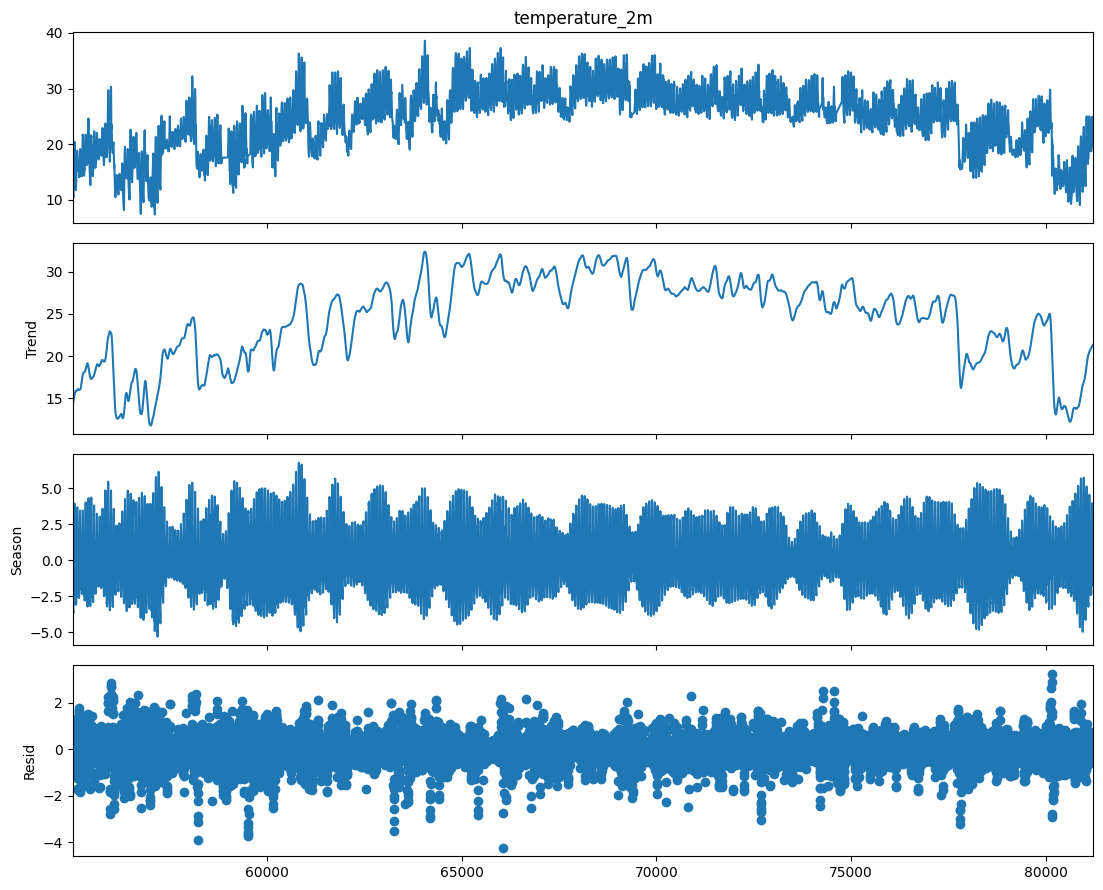

In [33]:
rcParams['figure.figsize'] = 11, 9
res = STL(df['temperature_2m'], period=24).fit()
res.plot()
plt.show()